# How to see what your agent did ?

## I - General plotting utilities

With the module "grid2op.PlotGrid" (more information on the official documentation [here](https://grid2op.readthedocs.io/en/latest/plotgrid.html)) it is possible to gather visual insights (plots) about the state of the powergrid.

This module currently involves 2 "base" classes:
- `PlotMatplot` which uses the well-known matplotlib python library to render the plot. Matplotlib being the most used plotting library in python, we decided to add its support in grid2op.
- `PlotPlotly` that uses the plotply library. Plotly is particularly suited for studying more deeply what happens at some particular time step.

It is not recommended to use any of these. Rather, we developped two higher-level classes:
- `EpisodeReplay` which uses the "PlotMatplotlib" class internally and is used to render a video as a gif or a mp4 file. This is mainly designed to communicate the results of your agent.
- `env.render` which is similar to the gym method `env.render` that all people used to the open ai gym framework will be familiar with.

Last but not least, a package called `grid2viz` has been developped to help you diagnose in-depth the behaviour of your agent. This package is much more advanced than all the other methods presented above and we highly recommend you to use this package to get the best out of your agents!

In [1]:
import matplotlib.pyplot as plt  # pip install matplotlib
import seaborn as sns # pip install seaborn
import plotly.graph_objects as go  # pip install plotly
import imageio  # pip install imageio

This notebook will not work if one of the 4 packages above cannot be imported. We highly recommend that you install them on your machine. We provide you with the pip commands so that you can install them easily.

In [2]:
import grid2op
env = grid2op.make(test=True)

D:\Anaconda3\Lib\site-packages\grid2op\MakeEnv\Make.py:224: UserWarning:

You are using a development environment. This environment is not intended for training agents.



## II - Plot.Plotting utility

Tthe "Plot.Plotting" module can help render a powergrid using 2 different methods: matplotlib or plotly. The display method is defined when you create a "plotting" object as shown below.

All functions exposed here are available for plotly and matplotlib. Feel free to switch from one to the other in order to see the differences.


### II A) Plot Static informations
The next cell will plot the names of each object on the powergrid, as well as their id.

------------ TODO ----------- check that the next plot displays the powerlines names

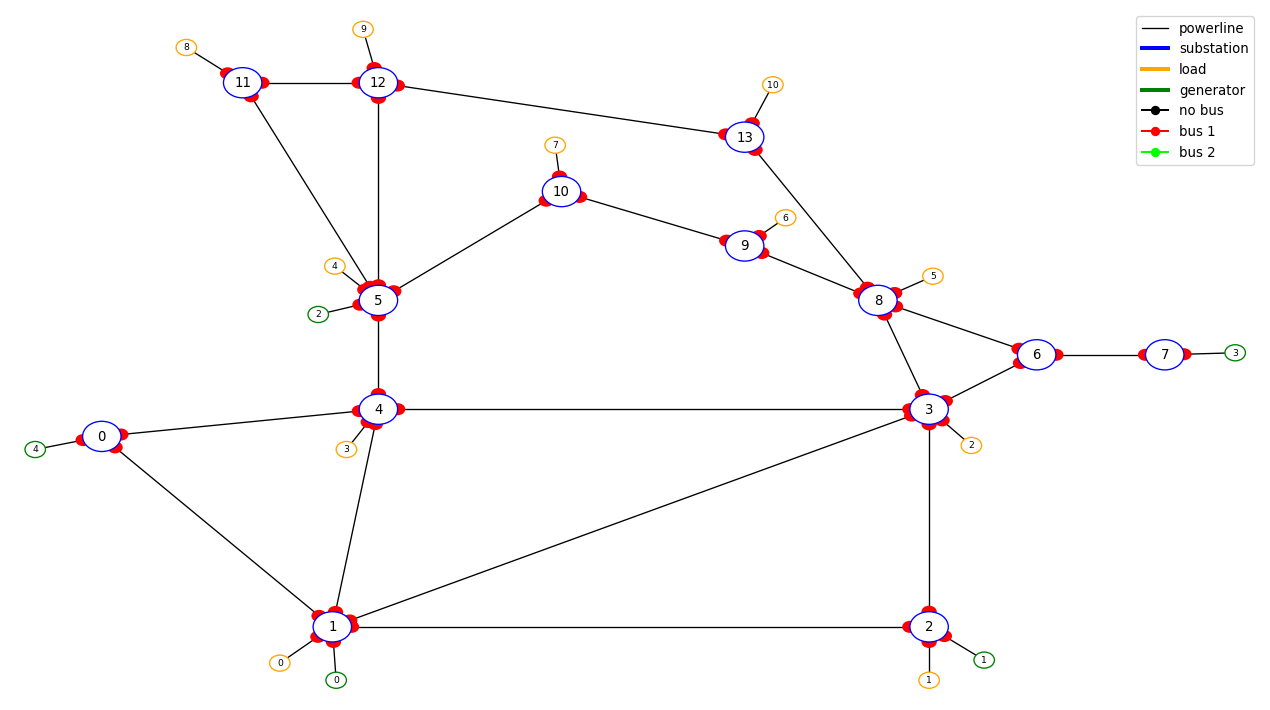

In [3]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
line_ids = [int(i) for i in range(env.n_line)]
fig_layout = plot_helper.plot_layout()

It is also possible to display some "external" information on this layout For example, you can plot the thermal limit of each powerline:

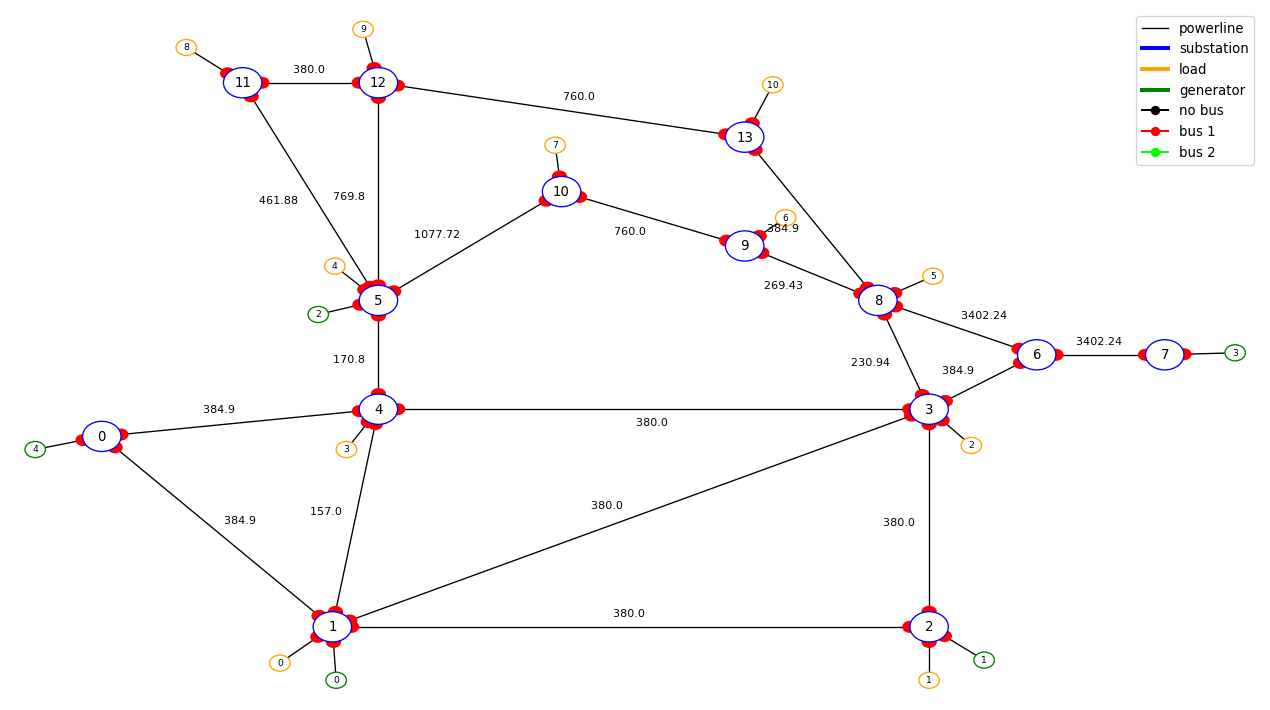

In [4]:
fig_info = plot_helper.plot_info(line_values=env._thermal_limit_a)

The argument "line_values" tells the information on the powerlines that you wish to display. Here, the thermal limits of the powerlines are displayed.

It is also possible to display information abouts loads and generators in the same manner.

### II - B) Plot a few observations


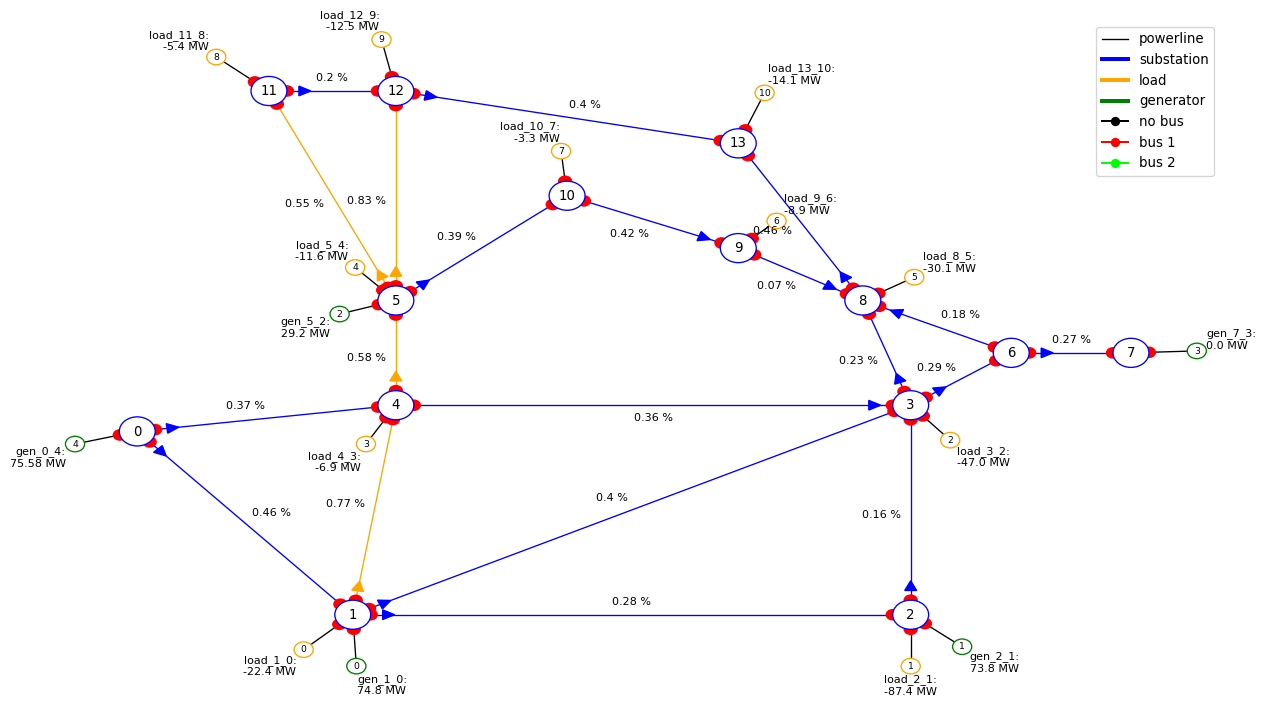

In [5]:
obs = env.reset()
fig_obs = plot_helper.plot_obs(obs)

Here you can see that the powerlines are colored with respect to their flow (in % of the thermal limit). Blue lines are the powerlines where the flow is rather low, while orange lines have higher flows. Loads consumptions and generators productions are provided with the injections (+ for generators, - for loads) given in MW.

All this can be modified as showed in the cell below, where we plot the active power flow for the powerlines and the load voltage magnitude for the loads. Notice that the units will be different for the loads since we now display voltages instead of consumptions.

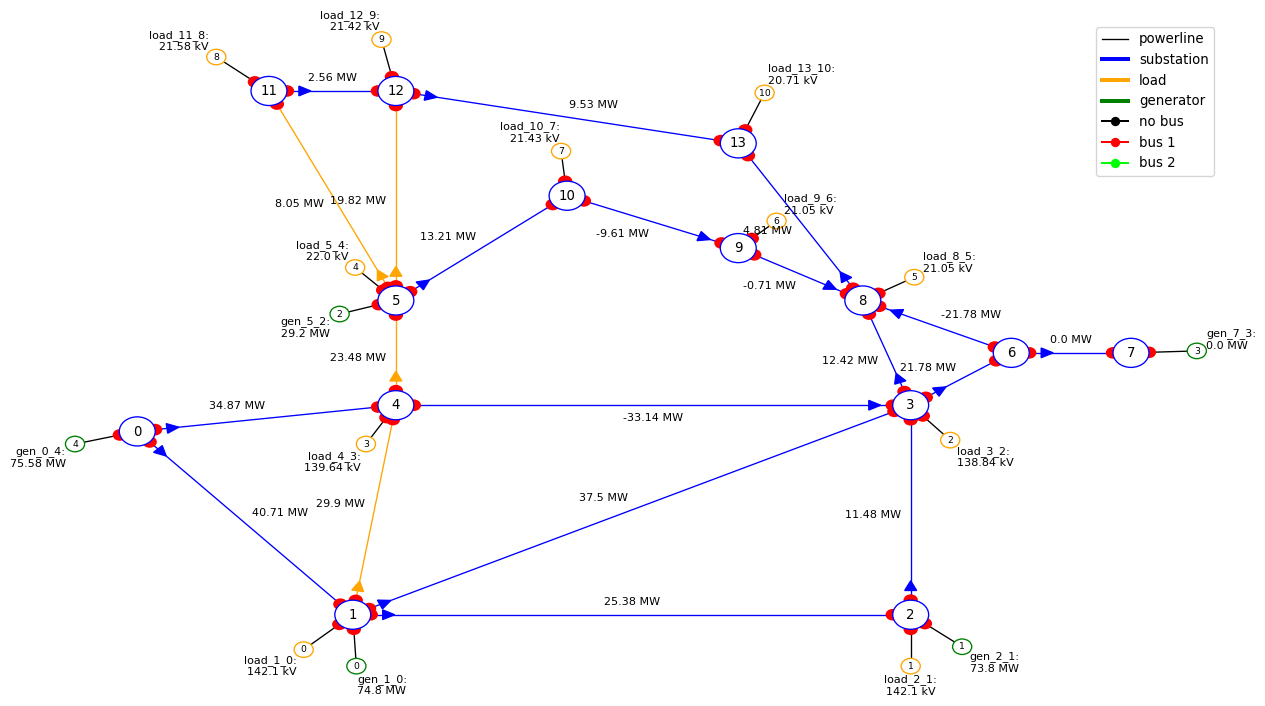

In [6]:
fig_obs2 = plot_helper.plot_obs(obs, line_info="p", load_info="v")

Finally, the topology at each substation can also be plotted. For example, let's consider a topological action at substation 1.

We will move the load there (the load 'load_1_0') and the powerlines '0_1_0' and '1_3_3' to the bus number 2. You can see the names of the loads, generators and powerlines on the first plot in this notebook. This can be done easily, as shown in the cell below (see notebook [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) for more information).

----------- TODO ---------- use names in the next cell instead of IDs

In [7]:
action = env.action_space({"set_bus": {"loads_id": [(0,2)], "lines_or_id": [(3,2)], "lines_ex_id": [(0,2)]}})
print(action)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (extremity) 0 [on substation 1]
	 	 - assign bus 2 to line (origin) 3 [on substation 1]
	 	 - assign bus 2 to load 0 [on substation 1]


The `print` utility helps us check that the action we implemented was indeed the one that we wanted to implement. `print` is also a nice way to see what happened sometimes.

Now let's perform that action and plot the new observation :

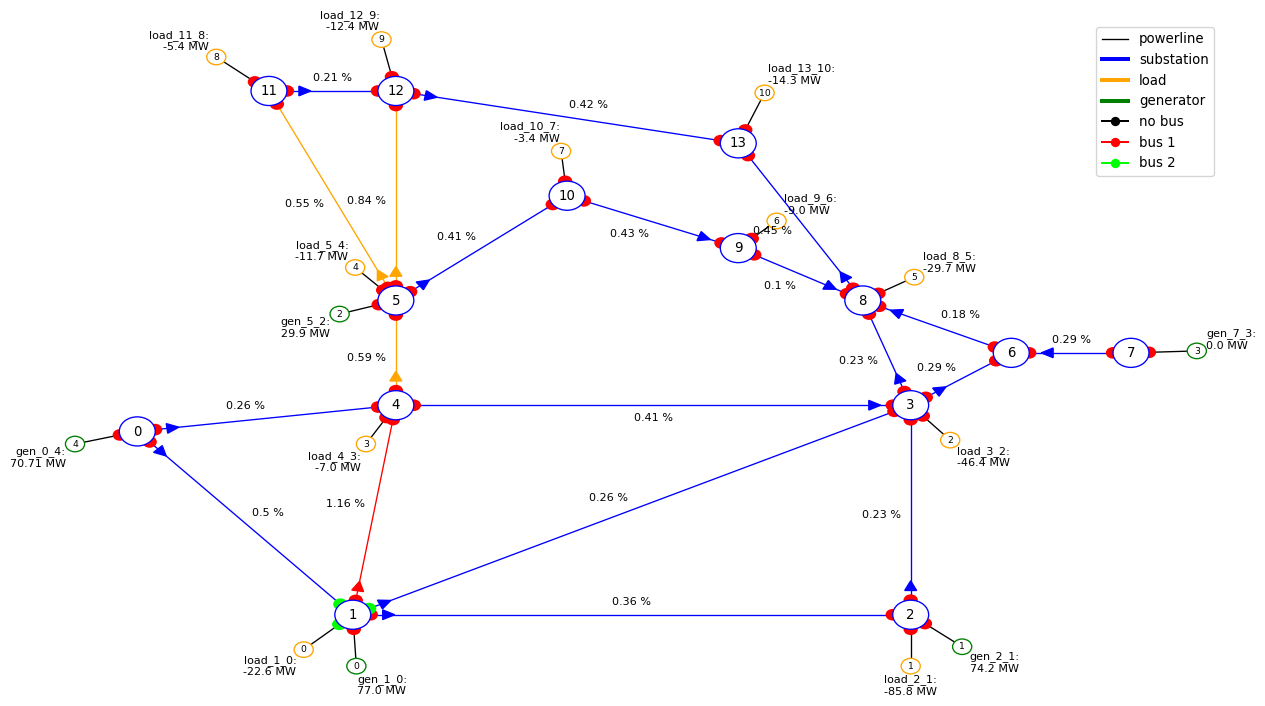

In [8]:
new_obs, reward, done, info = env.step(action)
fig_obs3 = plot_helper.plot_obs(new_obs)

On the previous observation, all the objects (loads, generators and powerlines) were connected to the bus 1, shown in red.

Here, the 3 objects that we wanted to connect to the bus 2 (the load 'load_1_0', the extremity of '0_1_0' and the origin of '1_3_3') are indeed connected to the second bus, which is shown in green.

This plotting utility is a pretty useful tool to detect what happened, especially just before a game over.

## III - env.render

Another way to inspect what is going on while the episode is happening is to use the renderer. The renderer can be used as in any open ai gym environment. 

In the next cell we will: reset the environment created above, create an agent that takes random actions every 10 timesteps and see how it goes.

**NB** It is not recommended to train your agent with any renderer turned on. The preferred way is to train your agent without any renderer first, and then to evaluate your agent on a fixed set of scenarios while possibly turning the renderer on (more information about this in the next section).

-------------- TODO ---------------- the cell below does not display an output when the notebook is run

In [9]:
%%capture
from grid2op.Agent import RandomAgent

class CustomRandom(RandomAgent):
    def __init__(self, action_space):
        RandomAgent.__init__(self, action_space)
        self.i = 1

    def my_act(self, transformed_observation, reward, done=False):
        if (self.i % 10) != 0:
            res = 0
        else:
            res = self.action_space.sample()
        self.i += 1
        return res
    
myagent = CustomRandom(env.action_space)
obs = env.reset()
reward = env.reward_range[0]
done = False
while not done:
    env.render()
    act = myagent.act(obs, reward, done)
    obs, reward, done, info = env.step(act)
env.close()

## IV - ReplayEpisode

This tool allows you to save a gif of the rendering of your agent. We recommend, as stated above, to get rid of any renderer in the training phase, and then to use the runner to assess the performance of your agent. Then, once the results are saved by the runner, you can use the `ReplayEpisode` class or study it more in depth with grid2viz (see next section). 

But first things first, let's mimic what we think is a good process. Suppose you are happy with the result of your agent (for the sake of simplicity we will not train any agent here, we will use an untrained instance of our CustomRandom agent). What are the next steps?

First, you need to create an environment on which it will be evaluated, and use a runner for the evaluation:

In [10]:
from grid2op.Runner import Runner
env = grid2op.make(test=True)
my_awesome_agent = CustomRandom(env.action_space)
runner = Runner(**env.get_params_for_runner(), agentClass=None, agentInstance=my_awesome_agent)

D:\Anaconda3\Lib\site-packages\grid2op\MakeEnv\Make.py:224: UserWarning:

You are using a development environment. This environment is not intended for training agents.



Second, you must start the runner and save the result in a directory (here we limit the runner to perform only 30 iterations so that this notebook runs quickly):

In [11]:
import os
path_agents = "path_agents"  # this is mandatory for grid2viz to have a directory with only agents
# that is why we have it here. It is aboslutely not mandatory for this more simple class.
max_iter = 30  # to save time we only assess performance on 30 iterations
if not os.path.exists(path_agents):
    os.mkdir(path_agents)
path_awesome_agent_log = os.path.join(path_agents, "awesome_agent_logs")
res = runner.run(nb_episode=2, path_save=path_awesome_agent_log, max_iter=max_iter)

Third, you must use the results of the runner and save the results as gif for example (you can also visualize it offline on the screen if you prefer : in order to do that, you simply need to switch the "display" argument to ``True``).

In [12]:
%%capture
from grid2op.Episode import EpisodeReplay
gif_name = "episode"
ep_replay = EpisodeReplay(agent_path=path_awesome_agent_log)
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    ep_replay.replay_episode(chron_name,  # which chronic was started
                             gif_name=gif_name, # Name of the gif file
                             display=False,  # dont wait before rendering each frames
                             fps=3.0)  # limit to 3 frames per second

And you can even see the gif in the jupyter notebook afterwards

This only works if:
- you haven't changed path_awesome_agent_log
- you haven't changed the name of gif_name
- all the above cells have be run properly

![img](./path_agents/awesome_agent_logs/000/episode.gif)

## V - Grid2Viz

This tool is really useful to dive deep into the analysis of your agent. We highly recommend that you use it to develop stronger agents and score high in the competition.

Grid2viz is a package that has been developped to help you visualize the behaviour of your agent. 

It is available in the github repository [grid2viz](https://github.com/mjothy/grid2viz). In the following cells we will demonstrate how to use it in order to inspect more deeply the log of our agent that was generated by the runner in the second cell of this notebook.

In this section, we first run some other agents to show the full potential of grid2viz (optional). Then we explain that the folder tree must respect a certain architecture for Grid2Viz to be used. Finally, we show how to install it and how to use it on the data generated in this notebook.

![](https://raw.githubusercontent.com/mjothy/grid2viz/master/grid2viz/assets/screenshots/scenario_overview.png)

### V - 1) More agents to compare

This section is not mandatory, but it is recommended to read it to discover the full capabilities of grid2viz. We will first run 2 others agents: the `DoNothing` agent, and the `TopologyGreedy` agent.

In [13]:
# make a runner for this agent
from grid2op.Agent import DoNothingAgent, TopologyGreedy
import shutil

for agentClass, agentName in zip([DoNothingAgent],  # , TopologyGreedy
                                 ["DoNothingAgent"]):  # , "TopologyGreedy"
    path_this_agent = os.path.join(path_agents, agentName)
    shutil.rmtree(os.path.abspath(path_this_agent), ignore_errors=True)
    runner = Runner(**env.get_params_for_runner(),
                    agentClass=agentClass
                    )
    res = runner.run(path_save=path_this_agent, nb_episode=2, 
                    max_iter=max_iter)
    print("The results for the {} agent are:".format(agentName))
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

The results for the DoNothingAgent agent are:
	For chronics with id 000
		 - cumulative reward: 34403.378906
		 - number of time steps completed: 30 / 30
	For chronics with id 001
		 - cumulative reward: 34420.378906
		 - number of time steps completed: 30 / 30


###  V - 2) Installation

Grid2Viz is not yet on pypi, but it is maintained as a Github repository, so you need a specific command to install it. It can be done easily by running the cell bellow (more information can be found on the grid2iz github).

In [14]:
import sys
print("To install it, either uncomment the cell bellow, or type, in a command prompt:\n{}".format(
    ("\t{} -m pip install git+https://github.com/mjothy/grid2viz.git --user --extra-index-url https://test.pypi.org/simple/".format(sys.executable))))

To install it, either uncomment the cell bellow, or type, in a command prompt:
	D:\Anaconda3\python.exe -m pip install git+https://github.com/mjothy/grid2viz.git --user --extra-index-url https://test.pypi.org/simple/


In [15]:
# !$sys.executable -m pip install git+https://github.com/mjothy/grid2viz --user --extra-index-url https://test.pypi.org/simple/

### V - 3) Usage

Once the above package is installed, you can start studying what your agent did (**NB** the agent must have been run with a runner and the "path_save" argument must have been provided in order for grid2viz to work properly.

For performance optimization, grid2viz uses a cache. This notebook being only an example, it is recommended to clear the cache before starting the grid2viz app. Of course, if you decide to study different generations of your agent, it is NOT recommended to clear the cache before any study.

In [16]:
shutil.rmtree(os.path.join(os.path.abspath(path_agents), "_cache"), ignore_errors=True)

In [17]:
!$sys.executable -m grid2viz.main --path=$path_agents

D:\Anaconda3\python.exe: Error while finding module specification for 'grid2viz.main' (ModuleNotFoundError: No module named 'grid2viz')
